In [1]:
from sklearn.preprocessing import Normalizer
import tensorflow as tf
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPool1D, Flatten, Dropout, Dense, BatchNormalization, Concatenate
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
import os

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")
import gc

import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import math
import lightgbm as lgb
from tqdm.notebook import tqdm
tqdm.pandas()

#!pip install Wordbatch
#from wordbatch.models import FTRL, FM_FTRL  # https://github.com/anttttti/Wordbatch
import xgboost
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import scipy
import scipy.sparse
from scipy.sparse import hstack

from sklearn.metrics import mean_squared_log_error
import pickle
import regex as re
import os

from sklearn.model_selection import KFold
import numpy as np

!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


### Loading saved dataset

In [3]:
train_input = '../input/mercari-mlp-combined-data/results/mercari_mlp_train_input.npz'
val_input = '../input/mercari-mlp-data/mlp_data/mercari_mlp_val_input.npz'
test_input = '../input/mercari-mlp-combined-data/results/mercari_mlp_test_input.npz'

train_labels = '../input/mercari-mlp-combined-data/results/mercari_mlp_train_labels.npz'
val_labels = '../input/mercari-mlp-data/mlp_data/mercari_mlp_val_labels.npz'
test_labels = '../input/mercari-mlp-combined-data/results/mercari_mlp_test_labels.npz'

In [4]:
X_train = (scipy.sparse.load_npz(train_input))
y_train = (scipy.sparse.load_npz(train_labels))
X_val = scipy.sparse.load_npz(val_input)

X_test = (scipy.sparse.load_npz(test_input))
y_test = (scipy.sparse.load_npz(test_labels))
y_val = scipy.sparse.load_npz(val_labels)


In [5]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

print(type(X_train), type(y_train))
print(type(X_test), type(y_test))

(1302134, 103395) (1302134, 1)
(130214, 103395) (130214, 1)
(144682, 103395) (144682, 1)
<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.coo.coo_matrix'>
<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.coo.coo_matrix'>


In [6]:
y_train_arr = y_train.toarray()
y_val_arr = y_val.toarray()
y_test_arr = y_test.toarray()

In [7]:
# X_train = X_train.toarray()

### MLP Model

#### Model Creating

In [8]:
def create_simple_mlp_model(input_shape):   #input_shape=X_train.shape[1]
    model_in = Input(shape=(input_shape,), dtype='float32', sparse=True)
    out = Dense(192, activation='relu', kernel_regularizer=regularizers.l2(0.001))(model_in)
    out = Dropout(0.10)(out)
    out = Dense(128, activation='relu',  kernel_regularizer=regularizers.l1(0.0001))(out)
    #out = BatchNormalization()(out)
    out = Dense(64, activation='relu')(out)
    out = Dense(1)(out)
    model = Model(model_in, out)
    return model

In [9]:
# len_inputs = 109281
simple_model = create_simple_mlp_model(X_train.shape[1])
# simple_model = create_simple_mlp_model(len_inputs)
simple_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 103395)]          0         
_________________________________________________________________
dense (Dense)                (None, 192)               19852032  
_________________________________________________________________
dropout (Dropout)            (None, 192)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 19,885,057
Trainable params: 19,885,057
Non-trainable params: 0
_________________________________________________

#### Loading pretrained model from checkpoint

In [10]:
old_checkpoint_dir = '../input/mercari-mlp-checkpoints/mlp_checkpoints'
latest = tf.train.latest_checkpoint(old_checkpoint_dir)
latest

'../input/mercari-mlp-checkpoints/mlp_checkpoints/mlp_ckpt.ckpt'

In [11]:
simple_model.load_weights(latest)

#### Define Evaluation Method

In [12]:
def evaluate_dl_model(model, X_data, y_act):
    y_pred = model.predict(X_data)

    act_prices = np.exp(y_act)
    pred_prices = np.exp(y_pred)

    rms = np.sqrt(mean_squared_log_error(act_prices, pred_prices))
    return rms

In [13]:
# Testing checkpoint weights
rms_error=evaluate_dl_model(simple_model, X_test, y_test_arr)
print('RMLE on splitted test data:', rms_error)


RMLE on splitted test data: 0.42608646085481044


### Training Model from Checkpoint or Scratch

In [14]:
EPOCHS = 100
SAVING_ROUNTINE = 1
BATCH_SIZE = 256
adam = Adam(learning_rate=0.0003)

In [15]:
checkpoint_path = "./mlp_checkpoints/mlp_ckpt.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_freq = 'epoch',
    save_best_only=True)

lrschedule_1 = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.70, mode='min')

# For more info on EarlyStoppingdelCheckpoint, refer https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
earlystop = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

In [16]:
simple_model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.0003), metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [17]:
history = simple_model.fit(x=X_train, y=y_train_arr, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, validation_data=(X_val, y_val_arr),
                 callbacks=[cp_callback, lrschedule_1, earlystop])
# history = simple_model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, validation_split=0.1,
#                  callbacks=[cp_callback, lrschedule_1, earlystop])

Epoch 1/100
5087/5087 [==============================] - 39s 6ms/step - loss: 0.1631 - root_mean_squared_error: 0.3874 - val_loss: 0.1776 - val_root_mean_squared_error: 0.4057

Epoch 00001: val_loss improved from inf to 0.17765, saving model to ./mlp_checkpoints/mlp_ckpt.ckpt
Epoch 2/100
5087/5087 [==============================] - 33s 6ms/step - loss: 0.1629 - root_mean_squared_error: 0.3870 - val_loss: 0.1775 - val_root_mean_squared_error: 0.4055

Epoch 00002: val_loss improved from 0.17765 to 0.17751, saving model to ./mlp_checkpoints/mlp_ckpt.ckpt
Epoch 3/100
5087/5087 [==============================] - 33s 6ms/step - loss: 0.1632 - root_mean_squared_error: 0.3874 - val_loss: 0.1773 - val_root_mean_squared_error: 0.4053

Epoch 00003: val_loss improved from 0.17751 to 0.17734, saving model to ./mlp_checkpoints/mlp_ckpt.ckpt
Epoch 4/100
5087/5087 [==============================] - 33s 6ms/step - loss: 0.1624 - root_mean_squared_error: 0.3865 - val_loss: 0.1772 - val_root_mean_squared

### Evaluate performance on splitted test data

In [18]:
rms_error=evaluate_dl_model(simple_model, X_test, y_test_arr)
print('RMLE on splitted test data:', rms_error)

RMLE on splitted test data: 0.42656289721266755


### Plotting training process

In [19]:
print(history.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error', 'lr'])


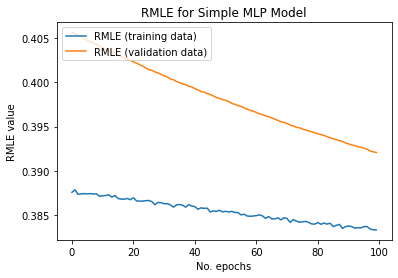

In [20]:
# Plot history: RMLE
plt.plot(history.history['root_mean_squared_error'], label='RMLE (training data)')
plt.plot(history.history['val_root_mean_squared_error'], label='RMLE (validation data)')
plt.title('RMLE for Simple MLP Model')
plt.ylabel('RMLE value')
plt.xlabel('No. epochs')
plt.legend(loc="upper left")
plt.show()

In [21]:
# def create_submission_output_file(model, X_data, bs=64):
#     submission_prices = model.predict(X_data, batch_size=bs)
#     submission_prices = np.exp(submission_prices)
#     submission_prices = np.squeeze(submission_prices, axis=1)
#     my_submission = pd.DataFrame({'test_id': test_df['test_id'], 'price': submission_prices})
#     my_submission.to_csv("./submission.csv", index=False)

In [22]:
# create_submission_output_file(simple_model, X_kaggle_test)

In [23]:
# test_df.shape